In [1]:
import numpy as np
import random

import cv2
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow.keras.datasets import mnist
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten, Rescaling
from keras.utils import np_utils

(60000, 28, 28)
(10000, 28, 28)


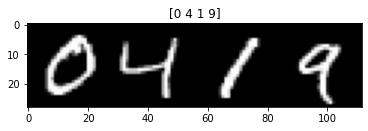

In [3]:
#loading dataset for digit classifier
(x_train,t_train),(x_test,t_test) = mnist.load_data()
print(x_train.shape)
print(x_test.shape)
plt.imshow(np.hstack(x_train[1:5]), cmap='gray')
plt.title(t_train[1:5])
plt.show()

Text(0.5, 1.0, '5')

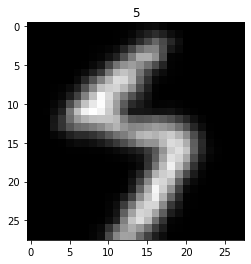

In [4]:
def rotate_image(image, angle):
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  return cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)

#rotate, rescales and resizes image
def rrrIMG(image):
    scale = random.choice(np.arange(40, 100.1, 0.01)) #choses scale from 40% to 100%
    new_dim = tuple((np.array(image.shape)*scale/100).astype('int'))
    resized = cv2.resize(image, new_dim, interpolation = cv2.INTER_AREA)
    
    angle = random.choice(np.arange(0, 360, 0.01))
    rotated = rotate_image(resized, angle)
    
    return cv2.resize(rotated, (28,28))
plt.imshow(rrrIMG(x_train[0]),cmap='gray')
plt.title(t_train[0])

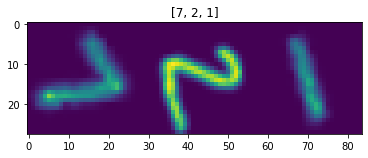

In [5]:
#will rescale and rotate images at random to allow code to be covariant to rotation and scaling
#while we are at it i will also augment dataset
data_train = []
label_train = []
for i in range(len(t_train)):
    for j in range(5):
        data_train.append(rrrIMG(x_train[i]))
        label_train.append(t_train[i])

data_test = []
label_test = []
for i in range(len(t_test)):
    data_test.append(rrrIMG(x_test[i]))
    label_test.append(t_test[i])        

plt.imshow(np.hstack(data_test[0:3]))
plt.title(label_test[0:3])
plt.show()

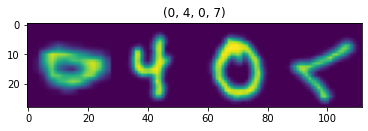

In [6]:
#shuffle training set so when training in batches it doesn't have similar pictures due to data augmentation
for i in range(100):
    c = list(zip(data_train, label_train))
    random.shuffle(c)
    data_train, label_train = zip(*c)

    c = list(zip(data_test, label_test))
    random.shuffle(c)
    data_test, label_test = zip(*c)

plt.imshow(np.hstack(data_train[0:4]))
plt.title(label_train[0:4])
plt.show()

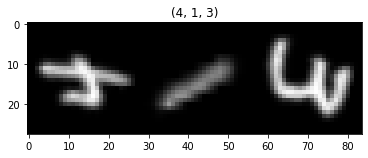

In [7]:
plt.imshow(np.hstack(data_test[0:3]),cmap='gray')
plt.title(label_test[0:3])
plt.show()

In [8]:
#one-hot encoding labels
n_classes = 10
y_train = np_utils.to_categorical(label_train, n_classes)
y_test = np_utils.to_categorical(label_test, n_classes)
print("Shape before: ", np.shape(label_train))
print("Shape after: ", y_train.shape)

Shape before:  (300000,)
Shape after:  (300000, 10)


In [9]:
#spliting and organizing arrays to work with keras model
xx_train, x_val, y_train, y_val = train_test_split(data_train, y_train, test_size=0.2, random_state=400196693)
xx_train = tf.expand_dims(np.array(xx_train,dtype='float32'),axis=3)
x_val = tf.expand_dims(np.array(x_val,dtype='float32'),axis=3)
xx_test = tf.expand_dims(np.array(data_test,dtype='float32'),axis=3)

In [129]:
tf.random.set_seed(400196693)

model = Sequential()
model.add(Rescaling(1./255))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPool2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(10, activation='softmax'))

# compile model
model.compile(optimizer="SGD", loss='binary_crossentropy', metrics=['accuracy'])

In [130]:
model.fit(xx_train, y_train, batch_size=128, epochs=15, validation_data=(x_val, y_val))

Epoch 1/15
1875/1875 [==============================] - 98s 52ms/step - loss: 0.2839 - accuracy: 0.3803 - val_loss: 0.2462 - val_accuracy: 0.5081
Epoch 2/15
1875/1875 [==============================] - 97s 51ms/step - loss: 0.2224 - accuracy: 0.5800 - val_loss: 0.2012 - val_accuracy: 0.6418
Epoch 3/15
1875/1875 [==============================] - 100s 53ms/step - loss: 0.1866 - accuracy: 0.6702 - val_loss: 0.1727 - val_accuracy: 0.7023
Epoch 4/15
1875/1875 [==============================] - 101s 54ms/step - loss: 0.1630 - accuracy: 0.7217 - val_loss: 0.1538 - val_accuracy: 0.7467
Epoch 5/15
1875/1875 [==============================] - 98s 52ms/step - loss: 0.1474 - accuracy: 0.7554 - val_loss: 0.1405 - val_accuracy: 0.7744
Epoch 6/15
1875/1875 [==============================] - 99s 53ms/step - loss: 0.1361 - accuracy: 0.7788 - val_loss: 0.1318 - val_accuracy: 0.7856
Epoch 7/15
1875/1875 [==============================] - 93s 50ms/step - loss: 0.1274 - accuracy: 0.7969 - val_loss: 0.1234

Text(0.5, 1.0, 'Training and Validation Accuracy')

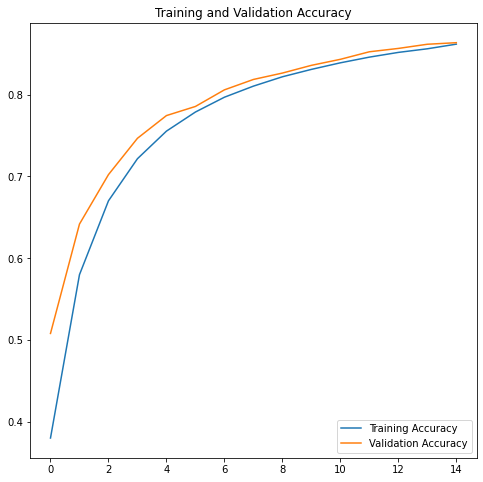

In [131]:
acc = model.history.history['accuracy']
val_acc = model.history.history['val_accuracy']
plt.figure(figsize=(8, 8))
plt.plot(range(15), acc, label='Training Accuracy')
plt.plot(range(15), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

In [132]:
test_accuracy = model.evaluate(xx_test, y_test, batch_size=128)
version = 4
modelpath = 'Classifiers/digitClassifier'+str(version)+'.h5'
model.save(modelpath)
model2 = tf.keras.models.load_model(modelpath)

79/79 [==============================] - 1s 12ms/step - loss: 0.0888 - accuracy: 0.8652


In [133]:
check = np.bitwise_and.reduce(np.bitwise_and.reduce(model.predict([xx_test[:4]])==model2.predict([xx_test[:4]])))
if (not(check)):
    print('ERROR SAVING MODEL')
else:

SAVED MODEL SUCCESSFULLY


In [ ]:
#MNIST dataset has zero padding around it, this will remove that and normalize each digit, i decided not to use this
trimmed = []
for i in range(len(x_train)):
    idx = np.nonzero(x_train[i])
    trimmed.append(x_train[i,idx[0].min():idx[0].max()+1, idx[1].min():idx[1].max()+1].astype('float64'))
    trimmed[-1] *= (255.0/trimmed[-1].max()) #normalizes image of digit
plt.imshow(np.hstack(trimmed[1:5]), cmap='gray')
plt.show()